<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/04%20investment%20portfolios%20with%20DCF.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

You can run the code examples in [Google Colab](https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/03%20investment%20portfolios.ipynb).

**To install the package:**

In [ ]:
!pip install okama

import okama and matplotlib packages ...

In [5]:
import warnings

import matplotlib.pyplot as plt

import okama as ok

plt.rcParams["figure.figsize"] = [12.0, 6.0]
warnings.simplefilter(action="ignore", category=FutureWarning)

Сlass **Portfolio** can be used to define investment strategies with cash flow - portfolo withdrawals / contributions.
Such strategy can be defined by additional parameters in `Portfolio`:
- the initial investment (`initial_amount` parameter)
- cash flows or withdrawals/contributions (`cashflow` parameter)

In [18]:
pf = ok.Portfolio(
    ["SPY.US", "AGG.US", "GLD.US"],
    weights=[0.60, 0.35, 0.05],
    ccy="USD",
    inflation=False,
    last_date="2024-01",
    rebalancing_period="year",
    initial_amount=300_000,  # portfolio initial investments
    cashflow=-2_000,  # portfolio monthly withdrawals
)
pf

symbol                       portfolio_2910.PF
assets                [SPY.US, AGG.US, GLD.US]
weights                      [0.6, 0.35, 0.05]
rebalancing_period                        year
currency                                   USD
inflation                                 None
first_date                             2004-12
last_date                              2024-02
period_length               19 years, 3 months
dtype: object

The discounted cash flow (DCF) methods can be used through construction:

`pf.dcf.weatlh_index`

## DCF Wealth Index

To plot the Portfolio wealth index with withdrawals:

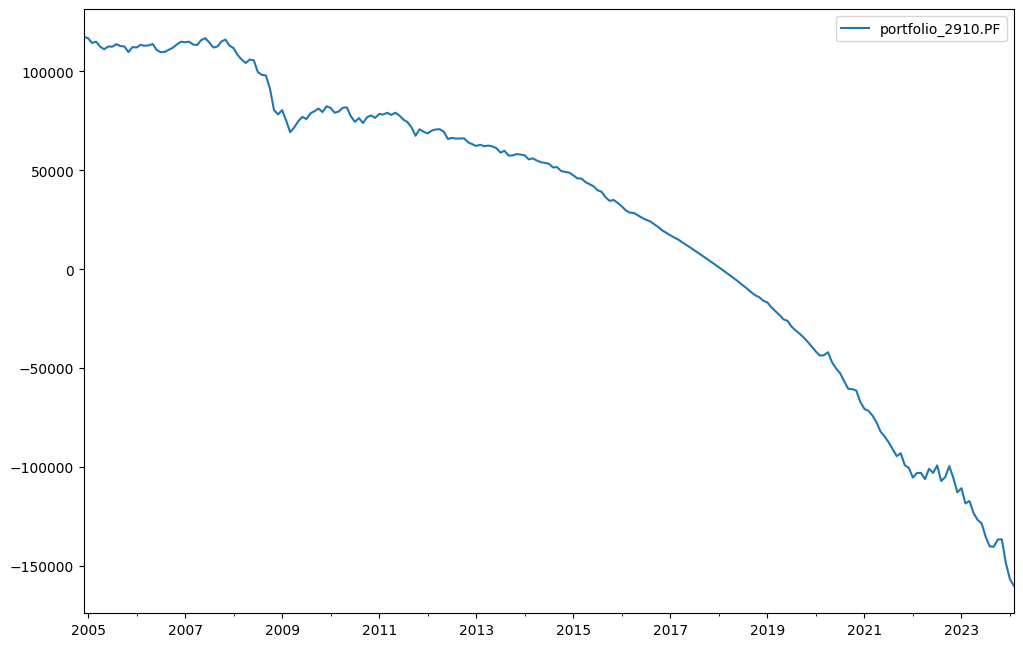

In [22]:
pf.dcf.wealth_index.plot();

The first value of the wealth index is the discounted value (PV) of the initial investments at the historical first date.

In [25]:
pf.initial_amount  # the initial value set in strategy

300000

In [26]:
pf.dcf.initial_amount_pv  # discounted value is initial value PV at `Portfolio.first_date`

117567.34550199384

In the above chart some portfolio values are negative starting form certain date. This date is called `survival_date`:

In [28]:
pf.dcf.survival_date  # the date when portfolio has zero value after withdrawals

Timestamp('2018-02-01 00:00:00')

In [30]:
pf.dcf.survival_period  # the period when portfolio has positive balance considering withdrawals

13.2

In situations when portfolio value does not reach 0 the survival date is set to `Portfolio.last_date`.

## Discount Rate

All the values can use `discount_rate` parameter to calculate PV. When the `discount_rate` is not set the value of average monthly inflation is used (when available) or the default value 0.05.

In [32]:
pf.discount_rate  # the Inflation=False and `discount_rate` is not set in Portfolio()

0.05

The `discount_rate` can be set to a suitable value:

In [33]:
pf.discount_rate = 0.07

In [35]:
pf.dcf.initial_amount_pv  # the value of initial investments PV changes

81837.56957759659

## Forecasting wealth index

Wealth index future scenarios can be simulated with Monte Carlos.

In [58]:
pf2 = ok.Portfolio(
    ["MCFTR.INDX", "RGBITR.INDX", "GC.COMM"],
    weights=[0.40, 0.40, 0.20],
    ccy="RUB",
    inflation=True,
    last_date="2024-01",
    rebalancing_period="year",
    initial_amount=600_000,  # portfolio initial investments
    cashflow=-4_000,  # portfolio monthly withdrawals
)

To plot the Monte Carlo simulation use `dcf.plot_forecast_monte_carlo()` method.

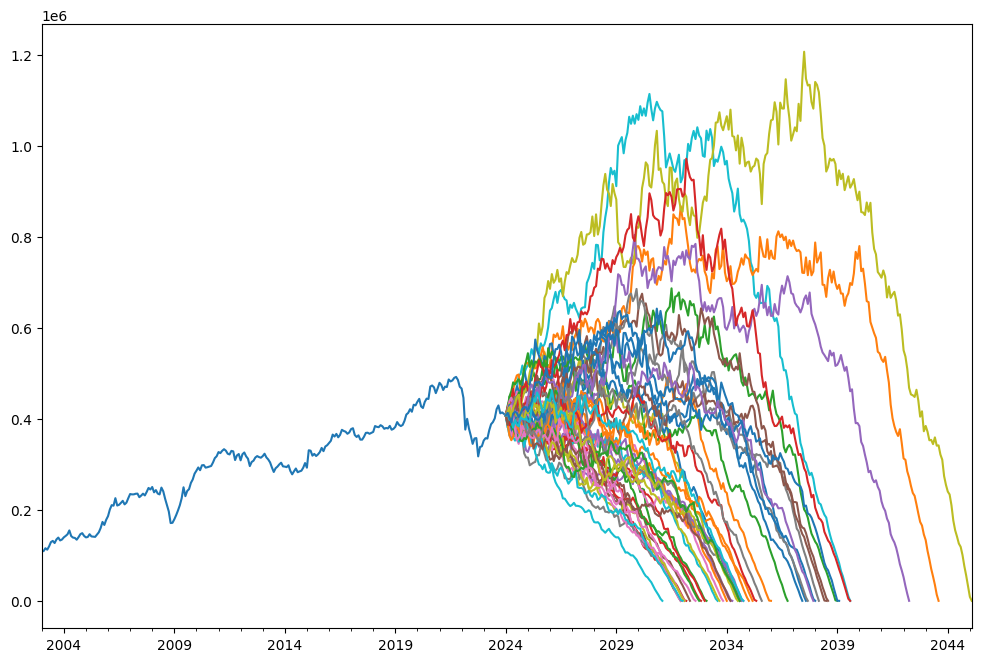

In [60]:
pf2.dcf.plot_forecast_monte_carlo(
    distr="norm",  # the rate of return distribution. Can be set to `norm` for normal distribution or `lognorm` for lognormal
    years=30,  # future period
    backtest=True,  # chose whether to plot backtest portfolio (True) or start from the future time series (False)
    n=50,  # Number of random time series generated by Monte Carlo
)

## Monte Carlo simulation for survival period

Plotting the future wealth indexes can help to visualize. However, more accurate data is needed to design invesntment strategies.

Portfolio survival period (or portfolio longevity) can be forecasted also by Monte Carlo simulation.

In [61]:
s = pf2.monte_carlo_survival_period(
    distr="norm",  # the rate of return distribution. Can be set to `norm` for normal distribution, `lognorm` for lognormal or 't' for Student's
    years=30,  # future period
    n=100,  # Number of random time series generated by Monte Carlo
)

`dcf.monte_carlo_survival_period()` method generate a Pandas Series with a distribution of future `survival periods`. This Series can be studied further:

In [62]:
s.describe()

count    100.000000
mean      20.126000
std        6.818537
min        8.800000
25%       14.875000
50%       18.800000
75%       27.325000
max       29.900000
dtype: float64

This strategy has mean survival period of 20+ years. The main distribution of future results is in 14 - 27 period.